In [1]:
from msc_project.analysis.analysis_utils import classify_model_parameters
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoConfig

In [ ]:
model_name = "distilbert/distilgpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)

In [4]:
categorised_weights = classify_model_parameters(model_name)

In [5]:
tensor = categorised_weights['attention_query']

In [9]:
tensor = categorised_weights['attention_query']
all_weights = torch.cat([t['weight'].flatten() for t in tensor])
all_biases = torch.cat([t['bias'].flatten() for t in tensor if 'bias' in t])

In [11]:
all_weights = all_weights.detach().cpu().numpy()
all_biases = all_biases.detach().cpu().numpy()

In [14]:
weights_mean = np.mean(all_weights)
weights_std = np.std(all_weights)
biases_mean = np.mean(all_biases)
biases_std = np.std(all_biases)

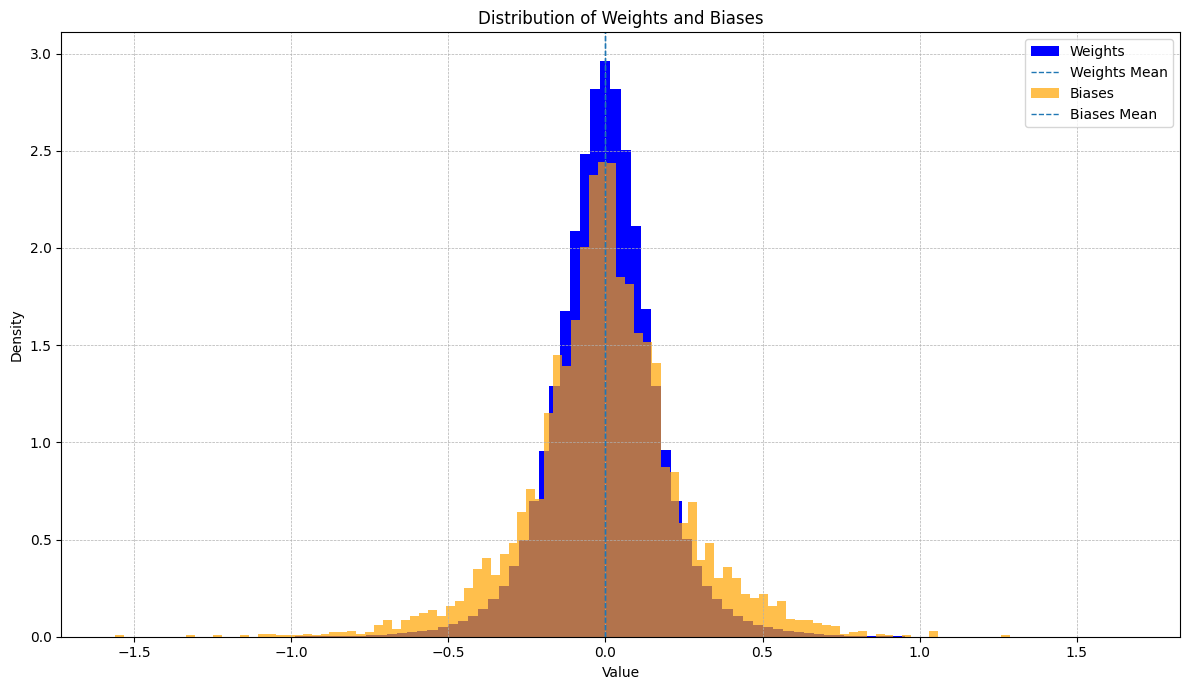

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.hist(all_weights, bins=100, density=True, label='Weights', color='blue')
ax.axvline(weights_mean, linestyle='dashed', linewidth=1, label='Weights Mean')
ax.hist(all_biases, bins=100, density=True, label='Biases', alpha=0.7, color='orange')
ax.axvline(biases_mean, linestyle='dashed', linewidth=1, label='Biases Mean')
ax.set_title('Distribution of Weights and Biases')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.legend()

ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()

plt.show()